Работа № 3
Для имеющихся временных рядов сделать:
1. Преобразование Фурье. (Изобразить диаграмму мощности гармоник, увидеть, чем периодический ряд отличается от хаотическогорю Use numpy.fft.fft)
2. Сингулярное спектральное разложение (Изобразить наиболее характерные компоненты с помощью pymssa).
3. Прогноз на несколько шагов с помощью SSA. (Будет охота поэкспериментировать с Фурье — тоже можно)
4. Изображение автокорреляционных функций для обоих рядов.

In [ ]:
!pip install git+https://github.com/kieferk/pymssa.git

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymssa import MSSA
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error

### Временной ряд с явными периодами

<Axes: title={'center': 'Daily min temperature'}, xlabel='date'>

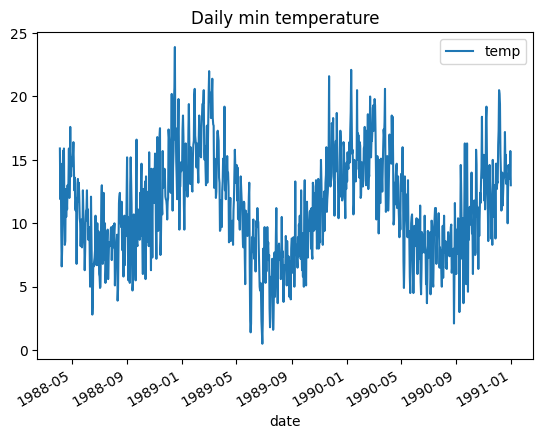

In [43]:
min_temp = pd.read_csv('data/daily-min-temperatures.csv')
min_temp = min_temp[-1000:]
min_temp.date = pd.to_datetime(min_temp.date)
min_temp = min_temp.set_index('date')
min_temp.plot(title="Daily min temperature")

### Хаотичный ряд

<Axes: title={'center': 'BTCUSDT 1m close price'}, xlabel='time'>

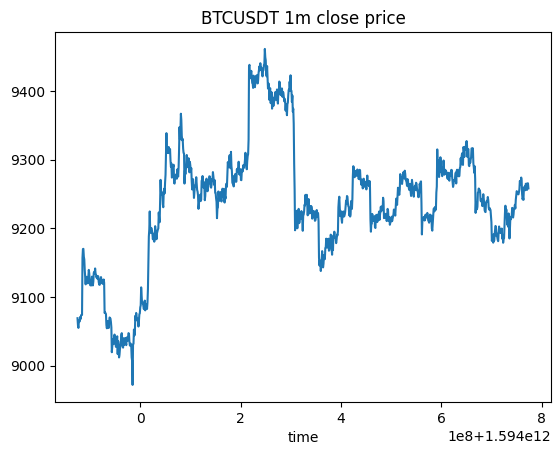

In [7]:
close_price = pd.read_csv('data/cryptoPrices15_wNB.csv')
close_price = close_price[['time','BTCUSDT']]
close_price = close_price[-1000:]
close_price= close_price.set_index('time')
close_price['BTCUSDT'].plot(title='BTCUSDT 1m close price')

### Преобразование Фурье

In [8]:
def get_fft_for_plot(data):
    fft = np.fft.fft(data)
    # Calculate frequencies
    freqs = np.fft.fftfreq(len(data), d=0.01)
    id = np.argmax(freqs < 0)
    # Calculate abs values
    fft_abs= np.abs(fft) / len(data)
    # return half of values
    return fft_abs[1:id]

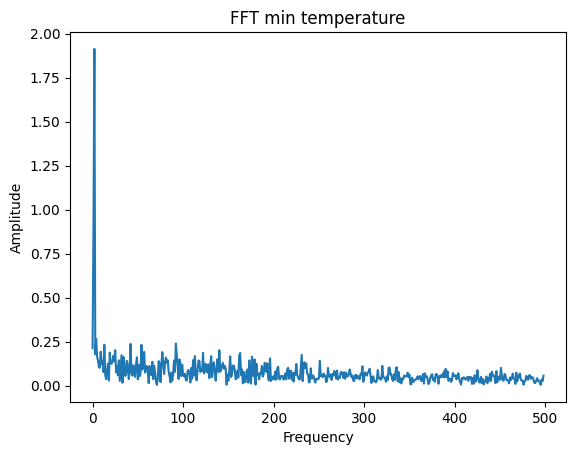

In [9]:
# For min temperature
plt.plot(get_fft_for_plot(min_temp.temp.tolist()))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('FFT min temperature')
plt.show()

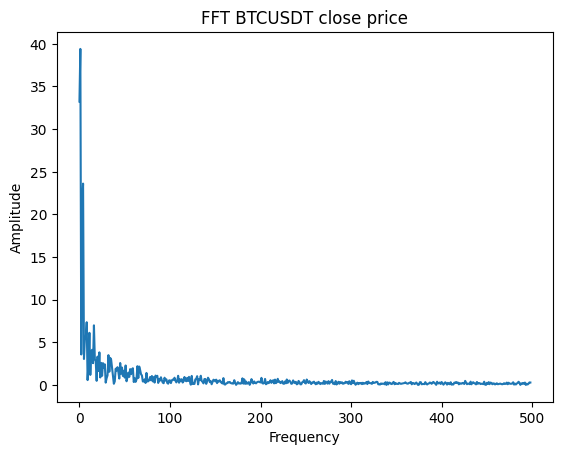

In [10]:
# For crypto prices
plt.plot(get_fft_for_plot(close_price['BTCUSDT']))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('FFT BTCUSDT close price')
plt.show()

In [31]:
# Видно, что амплитуда у периодичного ряда больше

### Сингулярное спектральное разложение

In [27]:
def get_mssa_for_plot(data):
    mssa = MSSA(n_components=4,
                window_size=30,
                verbose=True)
    mssa.fit(data)
    return mssa

Constructing trajectory matrix
Trajectory matrix shape: (30, 971)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders


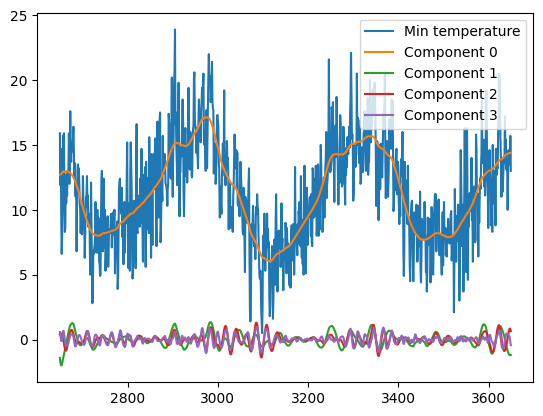

In [29]:
# For min temperature
mssa = get_mssa_for_plot(min_temp['temp'])

plt.plot(min_temp['temp'], label='Min temperature')
for component_number in range(4):
    component = mssa.components_[0, :, component_number]
    plt.plot(min_temp.index, component, label=f'Component {component_number}')

plt.legend()

Constructing trajectory matrix
Trajectory matrix shape: (30, 971)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders


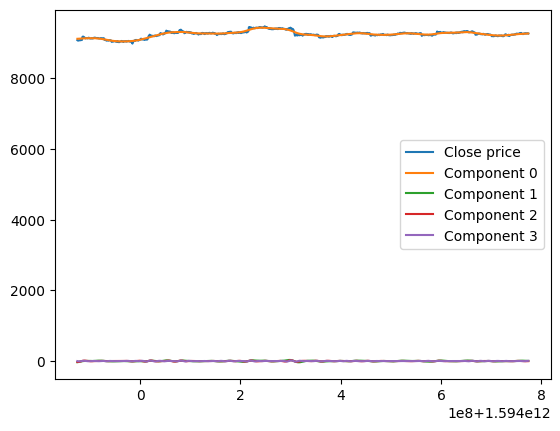

In [62]:
# For close price
mssa = get_mssa_for_plot(close_price['BTCUSDT'])

plt.plot(close_price['BTCUSDT'], label='Close price')
for component_number in range(4):
    component = mssa.components_[0, :, component_number]
    plt.plot(close_price.index, component, label=f'Component {component_number}')

plt.legend()

### Прогноз на несколько шагов с помощью SSA

In [ ]:
# ref: https://github.com/kieferk/pymssa#:~:text=wine_c%20%3D%20wine%20%2D%20tr_means

tp = 50
temp_te = min_temp.iloc[-tp:]
temp_tr = min_temp.iloc[:-tp]

mssa = MSSA(variance_explained_threshold=0.95,
            window_size=None,
            verbose=True)
mssa.fit(temp_tr)

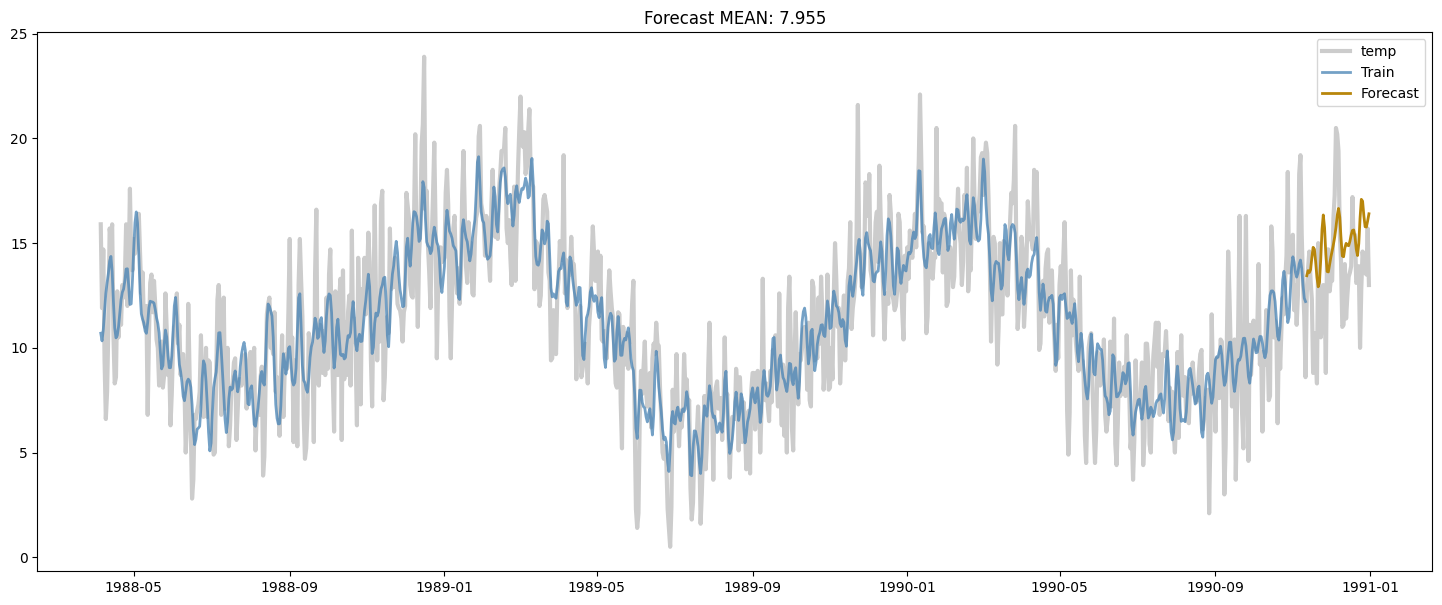

In [41]:
for ts_index in range(min_temp.shape[1]):
  tr = np.zeros(min_temp.shape[0])
  tr[:] = np.nan
  te = np.copy(tr)
  tr[:-tp] = mssa.components_[ts_index, :, :].sum(axis=1)
  fc = mssa.forecast(tp, timeseries_indices=ts_index)

  ytrue = temp_te.iloc[:, ts_index].values
  yhat = fc.ravel()[~pd.isnull(ytrue)]
  ytrue = ytrue[~pd.isnull(ytrue)]

  mean = mean_squared_error(ytrue, yhat)
  te[-tp:] = fc

  fig, ax = plt.subplots(figsize=(18, 7))
  ax.plot(min_temp.index, min_temp.iloc[:, ts_index].values, lw=3, alpha=0.2, c='k', label=min_temp.columns[ts_index])
  ax.plot(min_temp.index, tr, lw=2, c='steelblue', alpha=0.75, label='Train')
  ax.plot(min_temp.index, te, lw=2, c='darkgoldenrod', label='Forecast')
  ax.set_title(f'Forecast MEAN: {mean:.3f}')
  ax.legend()

  plt.show()

In [ ]:
tp = 50
close_price_te = close_price.iloc[-tp:]
close_price_tr = close_price.iloc[:-tp]

mssa = MSSA(variance_explained_threshold=0.95,
            window_size=None,
            verbose=True)
mssa.fit(close_price_tr)

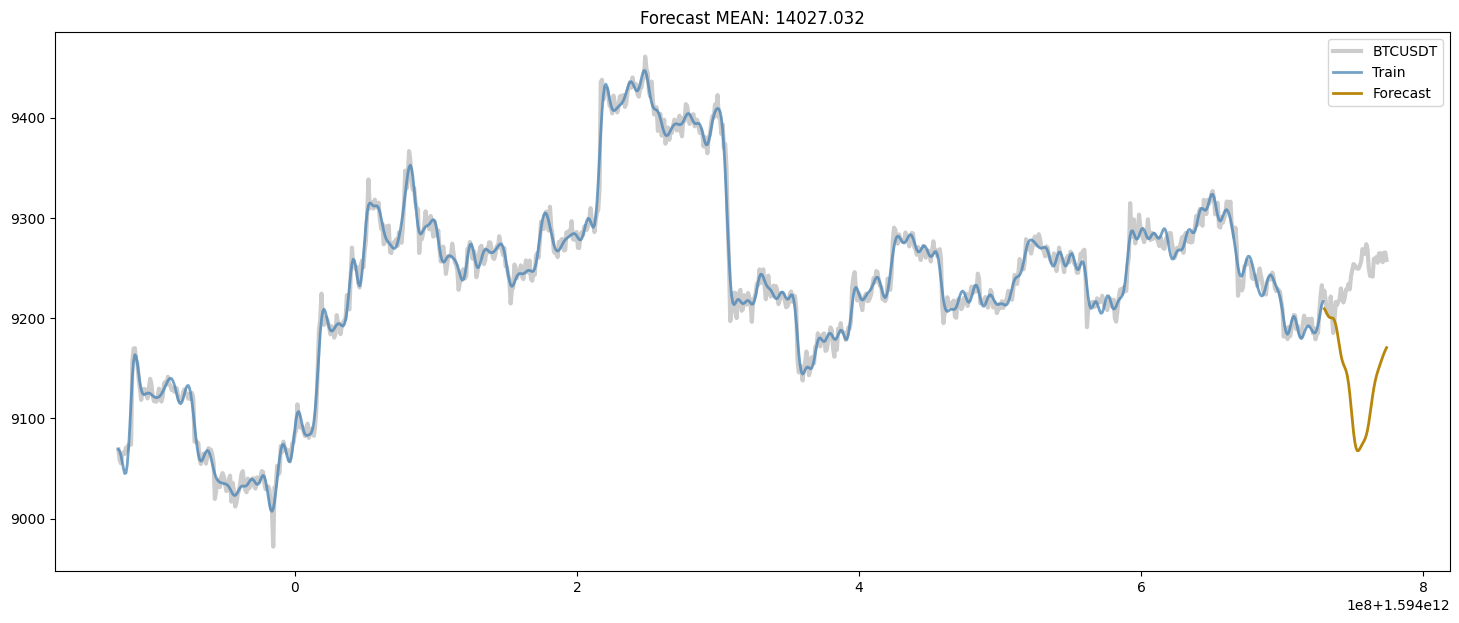

In [61]:
for ts_index in range(close_price.shape[1]):
  tr = np.zeros(close_price.shape[0])
  tr[:] = np.nan
  te = np.copy(tr)
  tr[:-tp] = mssa.components_[ts_index, :, :].sum(axis=1)
  fc = mssa.forecast(tp, timeseries_indices=ts_index)

  ytrue = close_price_te.iloc[:, ts_index].values
  yhat = fc.ravel()[~pd.isnull(ytrue)]
  ytrue = ytrue[~pd.isnull(ytrue)]

  mean = mean_squared_error(ytrue, yhat)
  te[-tp:] = fc

  fig, ax = plt.subplots(figsize=(18, 7))
  ax.plot(close_price.index, close_price.iloc[:, ts_index].values, lw=3, alpha=0.2, c='k', label=close_price.columns[ts_index])
  ax.plot(close_price.index, tr, lw=2, c='steelblue', alpha=0.75, label='Train')
  ax.plot(close_price.index, te, lw=2, c='darkgoldenrod', label='Forecast')
  ax.set_title(f'Forecast MEAN: {mean:.3f}')
  ax.legend()

  plt.show()

### Изображение автокорреляционных функций для обоих рядов

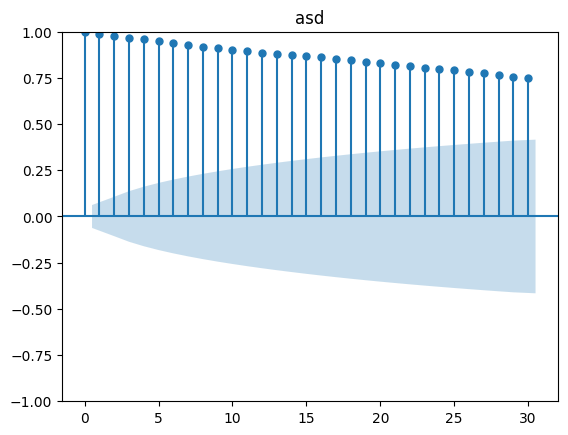

In [33]:
plot_acf(close_price['BTCUSDT'].values, title='Autocorrelation close price')
plt.show()

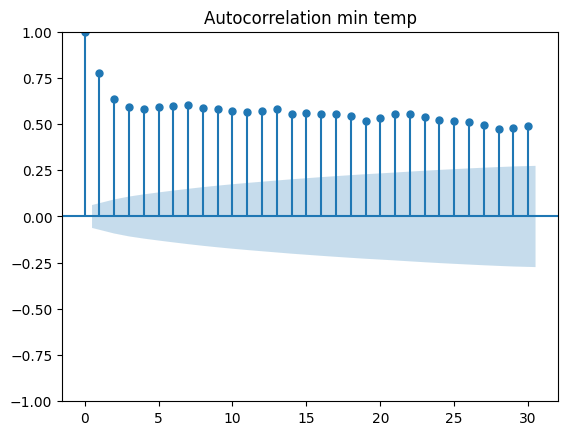

In [34]:
plot_acf(min_temp['temp'].values, title='Autocorrelation min temp')
plt.show()